In [86]:
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 30)

In [87]:
mydb = mysql.connector.connect(
    host="paks3.tmit.bme.hu",
    port = "8765",
    user="ficzere",
    password="fajaterdem",
    database = "matchodds_db")

print(mydb)

In [88]:
cursor = mydb.cursor()

cursor.execute("SHOW TABLES")

table_names = []
for table_name in cursor:
    table_names.append(table_name[0])

In [89]:
table_names

['American football',
 'Aussie rules',
 'Badminton',
 'Bandy',
 'Baseball',
 'Basketball',
 'Beach soccer',
 'Beach volleyball',
 'Boxing',
 'Cricket',
 'Darts',
 'Floorball',
 'Football',
 'Futsal',
 'Handball',
 'Hockey',
 'MMA',
 'Pesäpallo',
 'Rugby League',
 'Rugby Union',
 'Snooker',
 'Table tennis',
 'Tennis',
 'Volleyball',
 'Water polo',
 'eSports']

In [90]:
def read_table(table_name):
    cursor.execute(f'SELECT * FROM `{table_name}`')
    myresult = cursor.fetchall()
    df = pd.DataFrame(myresult)
    df.columns = (['home_team', 'away_team', '1', 'X', '2', 'result', 'date','time', 'country', 'competition', 'season' ])
    #df.columns = (['index', 'home_team', 'away_team', '1', 'X', '2', 'result', 'date','time', 'country', 'competition', 'season' ])
    return df

In [196]:
def create_probs(df):
    df = df[df['result'] != 'canceled']
    df = df[((df['result'] == 'X') & (df['X'] == np.inf)) == False]

    is_there_X = True
    if df['X'][0] is None:
        df['X'] = np.inf
        is_there_X = False



    norm_factor = 1 / (1 / df['1'] + 1 / df['X'] + 1 / df['2'] )
    df['norm'] = 1 / norm_factor
    probs = [1 / df['1'] * norm_factor, 1 / df['X'] * norm_factor, 1 / df['2'] * norm_factor]

    df['result_1'] = (df['result'] == '1').astype(int)
    df['result_X'] = (df['result'] == 'X').astype(int)
    df['result_2'] = (df['result'] == '2').astype(int)

    df['prob_1'] = probs[0]
    df['prob_X'] = probs[1]
    df['prob_2'] = probs[2]

    if is_there_X:
        df['cross_entropy'] = -(df['result_1'] * np.log(df['prob_1']) +
                                df['result_X'] * np.log(df['prob_X']) +
                               df['result_2'] * np.log(df['prob_2']))
        df['log_likelihood'] = (df['result_1'] * np.log(df['prob_1'])+
                            df['result_X'] * np.log(df['prob_X'])+
                            df['result_2'] * np.log(df['prob_2']))

    else: 
        df['cross_entropy'] = -(df['result_1'] * np.log(df['prob_1']) +
                               df['result_2'] * np.log(df['prob_2']))
        df['log_likelihood'] = (df['result_1'] * np.log(df['prob_1'])+
                            df['result_2'] * np.log(df['prob_2']))
        
    return df

In [212]:
len_df = {}
describe_df = {}
all_df = {}

for i in table_names:
    df = read_table(i)
    df = create_probs(df)
    print(i)
    len_df[i] = df.shape[0]
    describe_df[i] =  df['norm'].describe()
    all_df[i] = df

American football
Aussie rules
Badminton
Bandy
Baseball
Basketball
Beach soccer
Beach volleyball
Boxing
Cricket
Darts
Floorball
Football
Futsal
Handball
Hockey
MMA
Pesäpallo
Rugby League
Rugby Union
Snooker
Table tennis
Tennis
Volleyball
Water polo
eSports


In [254]:
all_df["Football"]

,home_team,away_team,1,X,2,result,date,time,country,competition,season,norm,result_1,result_X,result_2,prob_1,prob_X,prob_2,cross_entropy,log_likelihood
0,Sudan,Mauritania,4.07,3.13,2.01,2,2023-06-20,0 days 20:00:00,Africa,Africa Cup of Nations,2023,1.06,0,0,1,0.23,0.30,0.47,0.76,-0.76
1,Ethiopia,Malawi,2.80,2.86,2.77,X,2023-06-20,0 days 16:00:00,Africa,Africa Cup of Nations,2023,1.07,0,1,0,0.33,0.33,0.34,1.12,-1.12
2,Burundi,Namibia,3.32,2.88,2.41,1,2023-06-20,0 days 15:00:00,Africa,Africa Cup of Nations,2023,1.06,1,0,0,0.28,0.33,0.39,1.26,-1.26
3,Gabon,D.R. Congo,2.10,2.92,4.06,2,2023-06-18,0 days 20:00:00,Africa,Africa Cup of Nations,2023,1.06,0,0,1,0.45,0.32,0.23,1.46,-1.46
4,Cape Verde,Burkina Faso,2.48,2.81,3.32,1,2023-06-18,0 days 18:00:00,Africa,Africa Cup of Nations,2023,1.06,1,0,0,0.38,0.34,0.28,0.97,-0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298156,How Mine,Highlanders,2.21,3.28,2.80,X,2017-06-25,0 days 15:00:00,Zimbabwe,Premier Soccer League,2017,1.11,0,1,0,0.41,0.27,0.32,1.30,-1.30
1298157,Hwange,Shabanie,2.33,3.22,2.71,1,2017-06-25,0 days 15:00:00,Zimbabwe,Premier Soccer League,2017,1.11,1,0,0,0.39,0.28,0.33,0.95,-0.95
1298158,Triangle,ZPC Kariba,2.63,3.19,2.40,1,2017-06-25,0 days 15:00:00,Zimbabwe,Premier Soccer League,2017,1.11,1,0,0,0.34,0.28,0.38,1.07,-1.07
1298159,Chicken Inn,Ngezi Platinum,2.26,3.50,2.63,X,2017-06-24,0 days 15:00:00,Zimbabwe,Premier Soccer League,2017,1.11,0,1,0,0.40,0.26,0.34,1.36,-1.36


In [219]:
norm_factor_df = pd.DataFrame(describe_df).transpose()

In [105]:
norm_fact_df = {k: v for k, v in sorted(len_df.items(), key=lambda item: item[1])}
list(1/np.array(list(norm_fact_df.values())) - 1)

[0.11080999906703459,
 0.10550870297877868,
 0.10232894218792299,
 0.09932850529880755,
 0.09919092583708311,
 0.09513983133913029,
 0.09250429708627217,
 0.09095993012855086,
 0.08989971154725263,
 0.0898378198300811,
 0.08976338392254202,
 0.08932299416889222,
 0.08213438991005084,
 0.07914949327880572,
 0.07285032576260253,
 0.07270226319735729,
 0.0688257460118451,
 0.06771710579193568,
 0.0664723917010781,
 0.0644666891296144,
 0.06297943635495051,
 0.06161619149278463,
 0.061159019385119695,
 0.05657774762117973,
 0.05625272209564591,
 0.049142297327195994]

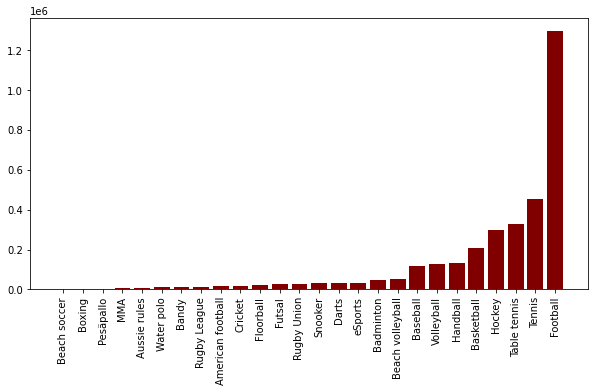

In [11]:
len_df = {k: v for k, v in sorted(len_df.items(), key=lambda item: item[1])}

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(list(len_df.keys()), list(len_df.values()), color ='maroon')
plt.xticks(rotation=90)
plt.show()

In [21]:
log_likelihood = {}

for i in table_names:
    ll_list = []
    df = read_table(i)
    df = create_probs(df)
    for j in range(100):
        ll = df['log_likelihood'].sample(1000,replace=True).sum()
        ll_list.append(ll)
        
    log_likelihood[i] = ll_list

In [27]:
ll_df = pd.DataFrame(log_likelihood)
ll_df.to_csv('/storage/ficzere/results/ll_df.csv')

In [15]:
log_likelihood = {k: v for k, v in sorted(log_likelihood.items(), key=lambda item: item[1])}
log_likelihood

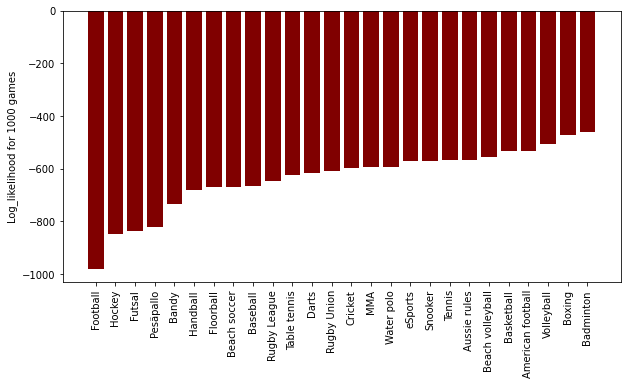

In [17]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(list(log_likelihood.keys()), list(log_likelihood.values()), color ='maroon')
plt.xticks(rotation=90)
plt.ylabel("Log_likelihood for 1000 games")
plt.show()

In [55]:
stat_df = ll_df.describe()
stat_df.loc['median'] = ll_df.median()
stat_df.loc['count'] = len_df

In [251]:
stat_df_t = stat_df.transpose()
pd.options.display.float_format = "{:,.2f}".format
stat_df_t = stat_df_t.sort_values(by = 'mean')
stat_df_t

,count,mean,std,min,25%,50%,75%,max,median
Football,"1,298,161.00",-970.45,13.27,"-1,005.43",-979.35,-969.26,-960.37,-945.14,-969.26
Hockey,"300,054.00",-841.19,11.70,-868.57,-848.73,-841.09,-833.00,-815.58,-841.09
Pesäpallo,"4,454.00",-835.41,20.84,-891.95,-851.13,-837.39,-819.51,-789.30,-837.39
Futsal,"26,439.00",-817.26,18.47,-870.20,-830.44,-814.45,-803.19,-775.02,-814.45
Bandy,"12,045.00",-729.52,17.66,-764.07,-742.72,-729.54,-719.12,-685.61,-729.54
Floorball,"22,254.00",-698.96,18.05,-741.13,-713.94,-697.77,-686.92,-654.94,-697.77
Handball,"131,094.00",-669.97,18.62,-712.18,-683.47,-669.65,-658.74,-628.59,-669.65
Baseball,"117,155.00",-668.42,6.27,-683.37,-672.96,-667.53,-664.12,-654.86,-667.53
Rugby League,"12,526.00",-642.98,19.19,-689.65,-656.95,-645.73,-626.03,-596.98,-645.73
Table tennis,"327,747.00",-639.05,7.71,-663.42,-643.81,-639.42,-634.16,-621.78,-639.42


In [64]:
stat_df_t.sort_values(by = 'mean').to_csv('/storage/ficzere/results/sport_odds_stats.csv')

In [225]:
plot_df = pd.concat([norm_factor_df['mean'],mean_df],axis=1)
plot_df.columns = ['norm', 'prob']

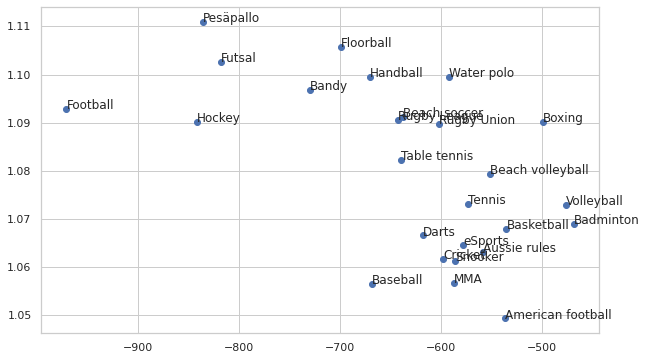

In [229]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(plot_df['prob'], plot_df['norm'])
for i, txt in enumerate(list(plot_df.index)):
    ax.annotate(txt, (plot_df['prob'][i], plot_df['norm'][i]))


In [253]:
stat_df.transpose().to_csv('/storage/ficzere/results/prob_stat_df.csv')
norm_factor_df.to_csv('/storage/ficzere/results/norm_factor_df.csv')